## 1.1 Model Hamiltonian

The model Hamiltonian is

$$
    H = \Omega (\sigma_x^{(1)} + \sigma_x^{(2)})
        e^{i [ \eta(a e^{-i\nu t} + a^{\dagger} e^{i\nu t}) - (\nu + \Delta)t]}
        + \textrm{h.c.}
$$

where $\Omega, \Delta$ are model parameters, $\nu$ is the motional frequency of the ion chain, and $\eta$ is the Lamb-Dicke parameter. 

The target Hamiltonian acts on a wavefunction as $U = e^{-iHt}$. 

## 1.2 Quantum channels

We can thus define an effective channel generated by a target Hamiltonian, written in a Kraus representation
$$
    \Psi_H[\rho] = e^{-iHt} \rho e^{iHt}
$$
or instead as process matrix
$$
    K[H] \vec{\rho} = e^{-iHt} \otimes e^{-iHt} \vec{\rho} 
$$
(we're using a row-stack convention, where $\vec{\rho} = \sum {\rho_{i,j}} |i\rangle |j\rangle$) or finally using double bra-ket notation
$$
    = K[H] | \rho \rangle \rangle. 
$$

Thus, for this 1-qubit model, we define probabiliy for 0 (dark-state):
$$
    p_0(t) \equiv P(0|\theta_1, \theta_2, t) = \langle \langle E_0| K[H(t)] | \rho \rangle \rangle
$$
and 1 (light-state):
$$
    p_1(t) \equiv P(1|\theta_1, \theta_2, t) = \langle \langle E_1 |K[H(t)] | \rho \rangle \rangle
$$
where $E_\mu$ is a measurement effect corresponding to 0 and 1. In the computational basis, $E_0 = (1, 0, 0, 0)$ and $E_1 = (0, 0, 0, 1)$

## 1.3 Probabilities

Okay, so everything before was overkill. Since we're assuming that we prepare the 0 state perfectly, we can just use the simpiler 
$$
    p_0(t) = | \langle 0 | e^{-iUt} | 0 \rangle |^2
$$
and 
$$
    p_1(t) = | \langle 1 | e^{-iUt} | 0 \rangle |^2
$$

## 1.4 multinomial distribution

We'll use a multinomial distribution for the outcomes (okay it's a binomial here, but for 2+ qubits it'll be multinomial)

$$
f(x_0, x_1 | p_0, p_1, t) = {(x_0 + x_1)! \choose x_0! x_1!} (p_0(t))^{x_0} (p_1(t))^{x_1} 
$$

## 1.5 Likelihood 

The likelihood is then 

$$
L(\theta_1, \theta_2 | x_0, x_1) = \prod_t f(x_0(t), x_1(t) | p_0, p_1, t) = 
$$$$
     \prod_t {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!}   (p_0(t))^{x_0(t)} (p_1(t))^{x_1(t)} 
$$


## 1.2 Log-Likelihood 

The log-likelihood is 
$$
    O(\vec{x}_0, \vec{x}_1) = \sum_t \log {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!} + \sum_t x_0(t) \log p_0(t) + \sum_t x_1(t) \log p_1(t)
$$ 

In [1]:
using IonSim
using QuantumOptics: timeevolution, stochastic
using StochasticDiffEq
using ScikitLearn
using Random
using Optim
using Distributions
using LinearAlgebra
import PyPlot
const plt = PyPlot;

## Define our trap

In [25]:
# calculate η
function calculate_η()
    ions = [Ca40(["S-1/2", "D-1/2"]), Ca40(["S-1/2", "D-1/2"])]
    chain = LinearChain(ions=ions, com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(;z=[1]))
    lasers = [
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2),
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2)
    ]
    trap = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=lasers)
    axial_mode = trap.configuration.vibrational_modes.z[1]
    axial_mode.N = 10
    return axial_mode, abs(get_η(axial_mode, lasers[1], ions[1]))
end

axial_mode, η = calculate_η();

In [26]:
function simulate_trap(tspan, detuning_khz, pi_time_μs)
    # defining trap parameters
    ca_ions = [Ca40(["S-1/2", "D-1/2"]), Ca40(["S-1/2", "D-1/2"])]
    chain = LinearChain(
        ions=ca_ions,
        com_frequencies=(x=3e6,y=3e6,z=1e6), 
        vibrational_modes=(;z=[1]),
    )
    lasers = [
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2),
        Laser(k = (x̂ + ẑ)/√2, ϵ = (x̂ - ẑ)/√2)
    ]
    trap = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=lasers)

    mode = trap.configuration.vibrational_modes.z[1]
    mode.N = 10

    Efield_from_pi_time!(pi_time_μs * 1e-6, trap, 1, 1, ("S-1/2", "D-1/2"));
    Efield_from_pi_time!(pi_time_μs * 1e-6, trap, 2, 1, ("S-1/2", "D-1/2"));
    
    Δ = detuning_khz * 1e3
    d = 35  # AC Stark shift compensation
    f = transition_frequency(trap, 1, ("S-1/2", "D-1/2"))
    
    detuned_lasers = [copy(lasers[1]), copy(lasers[2])]
    detuned_lasers[1].Δ = f + mode.ν + Δ - d
    detuned_lasers[2].Δ = f - mode.ν - Δ + d
    
    trap.lasers = detuned_lasers    

    h = hamiltonian(trap, timescale=1e-6, rwa_cutoff=1e5)
    @time tout, sol = timeevolution.schroedinger_dynamic(
        tspan, ca_ions[1]["S-1/2"] ⊗ ca_ions[2]["S-1/2"] ⊗ mode[0],
        h)
    
    SS = real.(expect(ionprojector(trap, "S-1/2", "S-1/2"), sol))
    DD = real.(expect(ionprojector(trap, "D-1/2", "D-1/2"), sol))
    SD = real.(expect(ionprojector(trap, "S-1/2", "D-1/2"), sol))
    DS = real.(expect(ionprojector(trap, "D-1/2", "S-1/2"), sol))
    
    return tout, SS, DD, SD, DS
end;

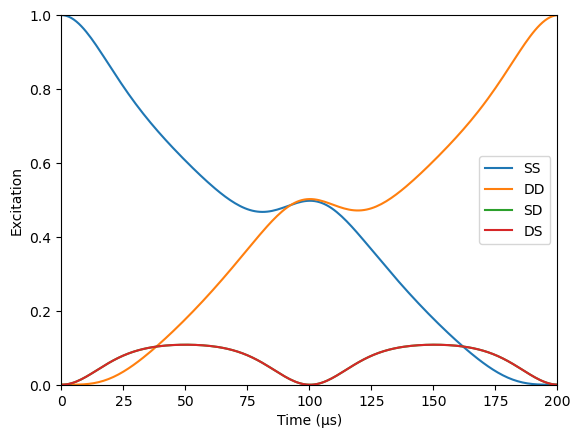

  0.007642 seconds (181.14 k allocations: 4.937 MiB)


In [27]:
ideal_detuning_khz = 10
ideal_pi_time_μs = 1e6 * η / (ideal_detuning_khz * 1e3)

tspan = 0:1:200
tout, SS, DD, SD, DS = simulate_trap(tspan, ideal_detuning_khz, ideal_pi_time_μs)

plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)")
plt.legend();

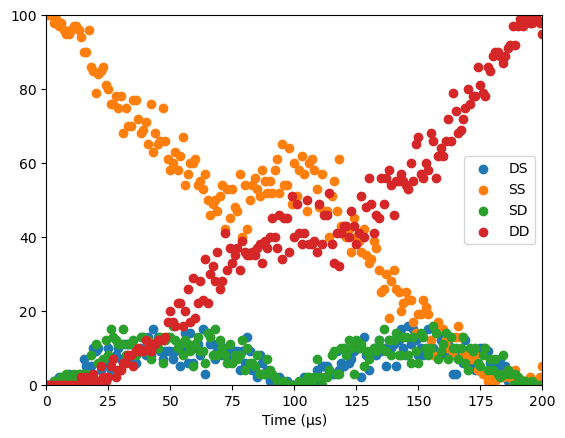

In [16]:
# function to simulate taking real data
function simulate_experiment(N, SS, DD, SD, DS)
    samples = []
    for i in eachindex(SS)
        sample = Dict("SS" => 0, "DD" => 0, "SD" => 0, "DS" => 0)
        for _ in 1:N
            number = rand(Float64)
            if number <= SS[i]
                sample["SS"] += 1
            elseif number <= SS[i] + DD[i]
                sample["DD"] += 1
            elseif number <= SS[i] + DD[i] + SD[i]
                sample["SD"] += 1
            else
                sample["DS"] += 1
            end
        end
        push!(samples, sample)
    end
    return samples
end

N = 100
samples = simulate_experiment(N, SS, DD, SD, DS)
for state in keys(samples[1])
    plt.scatter(tout, getindex.(samples, state), label=state)
end
plt.xlim(tout[1], tout[end])
plt.ylim(0, N)
plt.xlabel("Time (μs)")
plt.legend();

## Try to define model using time-dependent H directly --> too difficult!

In [6]:
# model building
sigX = [0 1; 1 0]
sigZ = [1 0; 0 -1]
sigP = [0 0; 1 0]
ion_identity = Matrix(1.0I, 2, 2)

adag = Matrix(create(axial_mode).data)
a = Matrix(destroy(axial_mode).data)
motional_ground = fockstate(axial_mode, 0).data
motional_identity = Matrix(1.0I, axial_mode.N+1, axial_mode.N+1)

using QuantumOptics: Ket, GenericBasis, Operator

function prob_states(tspan, Ω, Δ, ν, η)
    # see eq. (5) from Roos: https://arxiv.org/pdf/0710.1204.pdf
    H = t -> (
        Ω *
        (kron(sigP, ion_identity, motional_identity) .+ kron(ion_identity, sigP, motional_identity)) *
        kron(ion_identity, ion_identity,
            (exp(-im*(ν+Δ)*t).+exp(im*(ν+Δ)*t)) * exp(im*(η*(a*exp(-im*ν*t).+adag*exp(im*ν*t))))
        )
    )
    
    vec_SS0 = kron([1, 0, 0, 0], motional_ground)
    vec_SD0 = kron([0, 1, 0, 0], motional_ground)
    vec_DS0 = kron([0, 0, 1, 0], motional_ground)
    vec_DD0 = kron([0, 0, 0, 1], motional_ground)

    # solve the time-dependent Hamiltonian
    basis = GenericBasis(length(vec_SS0))
    @time tout, solution = timeevolution.schroedinger_dynamic(
        tspan,
        Ket(basis, vec_SS0),
        (t, psi) -> Operator(basis, basis, H(t) + H(t)'));

    return [Dict(
            "SS" => abs(vec_SS0'*final_state.data)^2,
            "DD" => abs(vec_DD0'*final_state.data)^2,
            "SD" => abs(vec_SD0'*final_state.data)^2,
            "DS" => abs(vec_DS0'*final_state.data)^2,
    ) for final_state in solution]
end;

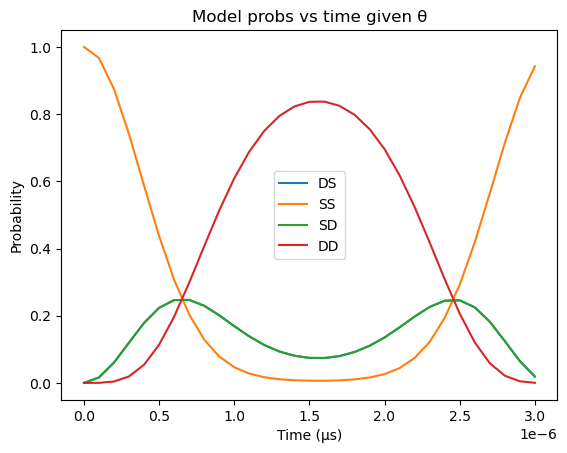

  7.428120 seconds (19.49 M allocations: 1.462 GiB, 4.38% gc time, 1.73% compilation time)


In [7]:
# model the the experimental outcomes
Ω = π / (ideal_pi_time_μs * 1e-6)
Δ = ideal_detuning_khz * 1e3

tspan = 0:0.1e-6:3e-6
outcomes = prob_states(tspan, Ω, Δ, axial_mode.ν, η)

for state in keys(outcomes[1])
    plt.plot(tspan, getindex.(outcomes, state), label=state)
end
plt.title("Model probs vs time given θ")
plt.xlabel("Time (μs)")
plt.ylabel("Probability")
plt.legend();

## Define our model, likelihood, and objective using IonSim.jl

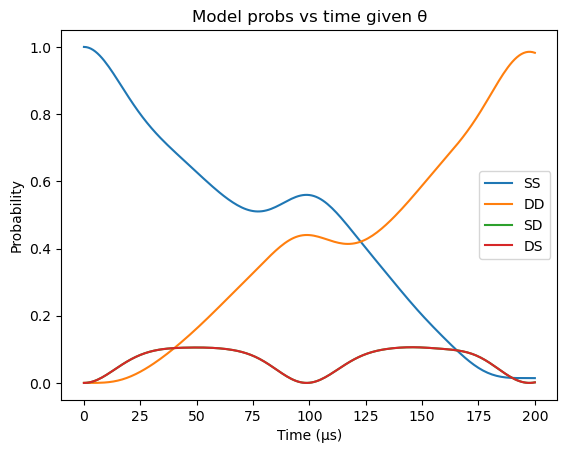

  0.283373 seconds (4.83 M allocations: 169.308 MiB, 12.63% gc time)


In [8]:
# model the the experimental outcomes with slight miscalibration
pi_time_μs = ideal_pi_time_μs * 1.02
Δ_khz = ideal_detuning_khz * 1.02

tspan = 0:1:200
tout, SS, DD, SD, DS = simulate_trap(tspan, Δ_khz, pi_time_μs)

plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")

plt.title("Model probs vs time given θ")
plt.xlabel("Time (μs)")
plt.ylabel("Probability")
plt.legend();

In [9]:
function log_likelihood(samples, num_experiments, times, θ₁, θ₂)
    """
    θ₁ = detuning_khz
    θ₂ = pi_time_μs
    """
    out = 0
    
    tout, p_SS, p_DD, p_SD, p_DS = simulate_trap(times, θ₁, θ₂)
    for i in eachindex(times)
        probabilities = [p_SS[i], p_DD[i], p_SD[i], p_DS[i]] ./ (p_SS[i] + p_DD[i] + p_SD[i] + p_DS[i])
        dist = Multinomial(num_experiments, probabilities)
        term = logpdf(dist, [samples[i]["SS"], samples[i]["DD"], samples[i]["SD"], samples[i]["DS"]])
        if term != NaN
            out += term
        end
    end
    
    return out
end

log_likelihood (generic function with 1 method)

## Make some batches of data and optimize

In [10]:
N = 100
samples = simulate_experiment(N, SS, DD, SD, DS)

function objective(θ::Vector)
    return -log_likelihood(samples, N, tout, θ[1], θ[2])
end

objective (generic function with 1 method)

In [11]:
log_likelihood(samples, 100, tout, ideal_detuning_khz, ideal_pi_time_μs)

  0.326239 seconds (4.91 M allocations: 172.241 MiB, 19.57% gc time, 3.71% compilation time)


-1389.6258188063591

In [12]:
initial_guess = [ideal_detuning_khz, ideal_pi_time_μs]
res = optimize(objective, initial_guess)

  0.347904 seconds (4.91 M allocations: 171.977 MiB, 20.17% gc time)
  0.287650 seconds (4.84 M allocations: 169.385 MiB, 11.46% gc time)
  0.060322 seconds (1.09 M allocations: 38.438 MiB)
  0.062531 seconds (1.10 M allocations: 38.517 MiB)
  0.108303 seconds (1.28 M allocations: 44.879 MiB, 26.08% gc time)
  0.065940 seconds (1.28 M allocations: 44.958 MiB)
  0.102994 seconds (1.75 M allocations: 61.454 MiB)
  0.132330 seconds (1.75 M allocations: 61.533 MiB, 21.96% gc time)
  0.164922 seconds (2.72 M allocations: 95.389 MiB)
  0.180262 seconds (2.71 M allocations: 94.996 MiB, 14.42% gc time)
  0.153868 seconds (2.30 M allocations: 80.778 MiB, 16.61% gc time)
  0.124427 seconds (2.29 M allocations: 80.385 MiB)
  0.174193 seconds (2.59 M allocations: 90.832 MiB, 15.01% gc time)
  0.149219 seconds (2.57 M allocations: 90.126 MiB)
  0.204916 seconds (3.08 M allocations: 108.114 MiB, 12.79% gc time)
  0.205185 seconds (3.04 M allocations: 106.700 MiB, 12.48% gc time)
  0.183153 seconds (

 * Status: success

 * Candidate solution
    Final objective value:     1.285629e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   37  (vs limit Inf)
    Iterations:    61
    f(x) calls:    132


In [13]:
Optim.minimizer(res)

2-element Vector{Float64}:
 10190.615581165042
     4.951034790689969e-6

In [14]:
Δ_khz, pi_time_μs

(10200.0, 4.942159390600016e-6)